In [1]:
import numpy as np
import pandas as pd
import requests
import io
from scipy import optimize
import matplotlib.pyplot as plt
import requests, pandas as pd
from bs4 import BeautifulSoup
import urllib.request
import et_xmlfile as et
import json
import scipy as sp

Citation: Moran, D., Kanemoto K; Jiborn, M., Wood, R., Többen, J., and Seto, K.C. (2018) Carbon footprints of 13,000 cities. Environmental Research Letters DOI: 10.1088/1748-9326/aac72a.

In [2]:
url = "https://citycarbonfootprints.info/GGMCF_top500citiesPercap.txt" # This is to get the data from the url. This file is not being saved locally.
df = pd.read_table(url) # Data is in txt file format. So read_table is needed.
df
df[['Footprint/Cap_value', 'margin']] = df['Footprint/Cap (t CO2/cap)'].str.split(' &', 1, expand=True)
df['margin'] = df['margin'].str.lstrip('plusmn;')
df['margin'].astype(float)
df['Footprint/Cap_value'].astype(float)
df['Urban Cluster'] = df['Urban Cluster'].str.replace('Country of Singapore', 'Singapore')
df['Urban Cluster'] = df['Urban Cluster'].str.replace('Hong Kong SAR', 'Hong Kong')
df['Urban Cluster'] = df['Urban Cluster'].str.replace(' ', '')
df = df.drop(columns=['Footprint (Mt CO2)', 'Footprint/Cap (t CO2/cap)'])
df


,Urban Cluster,Country,Population,1StdDev,ClusterID,Global ranking,Footprint/Cap_value,margin
0,HongKong,China,6029000,37.8,13847,1,34.6,6.3
1,MohammedBinZayedCity,UAE,188000,5.3,5292,2,32.9,27.9
2,AbuDhabi,UAE,911000,15.6,5288,3,32.9,17.1
3,Singapore,Singapore,5235000,34.1,13845,4,30.8,6.5
4,HulunBuir,China,198000,6.4,10441,5,30.0,32.3
...,...,...,...,...,...,...,...,...
495,"Unknowncityatlat/lon34.0,51.4",Iran,237000,1.6,5171,496,8.8,6.6
496,"Unknowncityatlat/lon35.4,116.9",China,471000,2.7,11975,497,8.8,5.8
497,"Unknowncityatlat/lon51.6,0.6",UK,250000,1.4,1836,498,8.8,5.4
498,"Unknowncityatlat/lon38.7,116.1",China,197000,1.6,11253,499,8.8,8.0


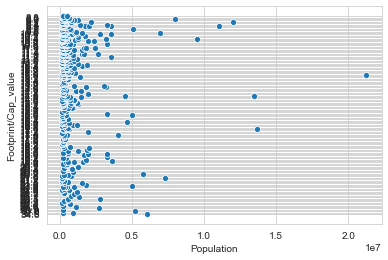

In [3]:
import seaborn as sns
sns.set_style('whitegrid')
sns.scatterplot(data=df,x='Population',y='Footprint/Cap_value')

EU GHSL - Global Human Settlement Layer data /
https://ghsl.jrc.ec.europa.eu/download.php?ds=pop

Citation: Corbane, Christina; Politis, Panagiotis; Syrris, Vasileios; Pesaresi, Martino (2018): GHS built-up grid, derived from 
Sentinel-1 (2016), R2018A. European Commission, Joint Research Centre (JRC) doi:10.2905/jrc-ghsl-10008 PID: 
http://data.europa.eu/89h/jrc-ghsl-10008

In [4]:
dens = pd.read_csv(r'C:\Users\vw191\OneDrive - University of Bristol\Course\3rd year\Data Science\Project\Datastore\eu_density_data.csv')
dfdens = pd.DataFrame(dens)
dfdens.head(1)
dfdens2 = dfdens[['ID_HDC_G0', 'CTR_MN_NM', 'CTR_MN_ISO', 'UC_NM_MN','P90', 'P00','P15', 'B15', 'BUCAP15', 'GDP15_SM', 'DEV_CMI', 'E_GR_AV14']] # These are the rows we want to keep.
# Row id, country name, country iso, city name, population in 1990, population in 2000, population in 2015, built up area in km2 in 2015, urban density, gdp in USD 2011 PPP prices, UN development level of country, average greeness located in the city in 2014 

C:\Users\vw191\Downloads\annaconda\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (20,21,22,23,28,31,32,33,34,55,56,57,58,159) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
#merge the co2 dataset (df) with the eu density df (dfdens2)
#fdf = full df
#mfdf = merged full df

mfdf = pd.merge(df, dfdens2,left_on='Urban Cluster',right_on='UC_NM_MN', how='right') # Merge on city name. I use a right merge to keep all the data from the EU density dataset.ClusterID
mfdf = mfdf.sort_values(['Population'],
              ascending = [True])
mfdf['pop_dens'] = mfdf['Population'].astype(float) / mfdf['B15'].astype(float) # Calculates population density with Population data taken from carboncityfootprints. B15 is the built up area in km2 for each city in 2015. The conversion to floats ensures that the calculation will work.




(-5.0, 15000.0)

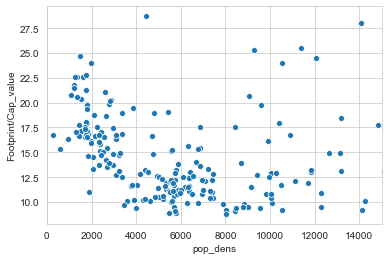

In [6]:
mfdf['BUCAP15'] = mfdf['BUCAP15'].astype(float)
mfdf['Footprint/Cap_value'] = mfdf['Footprint/Cap_value'].astype(float)
sns.set_style('whitegrid')
sns.scatterplot(data=mfdf[mfdf['Population'] > 100000],x='pop_dens',y='Footprint/Cap_value')
plt.xlim(-5,15000)

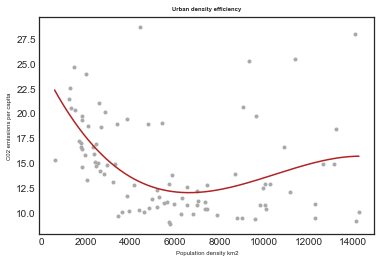

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
data = mfdf[['pop_dens', 'Footprint/Cap_value', 'Population', 'DEV_CMI','UC_NM_MN']].dropna() # To plot the chart we must filter out for null rows.
data = data[data['Population'] > 500000] # I am only interested in large cities with populations greater than 500,000 people.
x = data['pop_dens'][data['pop_dens'] < 15000] # Removing very dense cities that are outliers.
y = data['Footprint/Cap_value'][data['pop_dens'] < 15000] # Removing very dense cities that are outliers.


poly_model = make_pipeline(PolynomialFeatures(3), # Chosen a polynomial regression to see if there is a nonlinear relationship between per capita carbon emissions and urban density.
                           LinearRegression())
poly_model.fit(x[:, np.newaxis], y)
xfit = np.linspace(min(x), max(x), 1000) # Creating 1000 xfit values.
chart_fit = pd.DataFrame(data=poly_model.predict(xfit[:, np.newaxis]), columns = ['yfit'])
chart_fit['xfit'] = xfit # saving the fitted variables in a new df called chart_fit.
yfit = chart_fit['yfit'] # saving the fitted variables in a new df called chart_fit.
plt.style.use('seaborn-white') # Creating the sns chart to see the relationship.
plt.scatter(x, y, color='darkgrey', marker='.')
plt.plot(xfit, yfit ,color='firebrick')
plt.xlabel('Population density km2', size=6)
plt.ylabel('C02 emissions per capita', size=6)
plt.title('Urban density efficiency', size=6, weight='bold')

chart_fit = chart_fit.join(x)
chart_fit = chart_fit.join(y)
chart_fit['developed'] = data['DEV_CMI']
chart_fit['population'] = data['Population']
chart_fit['city_name'] = data['UC_NM_MN']
project1df = chart_fit
save = project1df.to_json(r'C:\Users\vw191\OneDrive\Documents\GitHub\107SBakst.github.io\data\project1df.json') # Uploads the new df as a json file straight to github repository.
save1 = project1df.to_csv(r'C:\Users\vw191\OneDrive\Documents\GitHub\107SBakst.github.io\data\project1df.csv')
#https://raw.githubusercontent.com/107SBakst/107SBakst.github.io/main/data/project1df.json This is the raw github url.